# **1. Setup and Load Data**

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

1.2 Remove dodgy images

In [5]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [6]:
data_dir = 'data'

In [7]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

1.3 Load Data 

In [9]:
import numpy as np

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 289 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
# Get another batch from the iterator
batch = data_iterator.next()

In [13]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [14]:
# Class 1 = SAD PPL
# Class 0 = HAPPY PPL
batch[1]

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

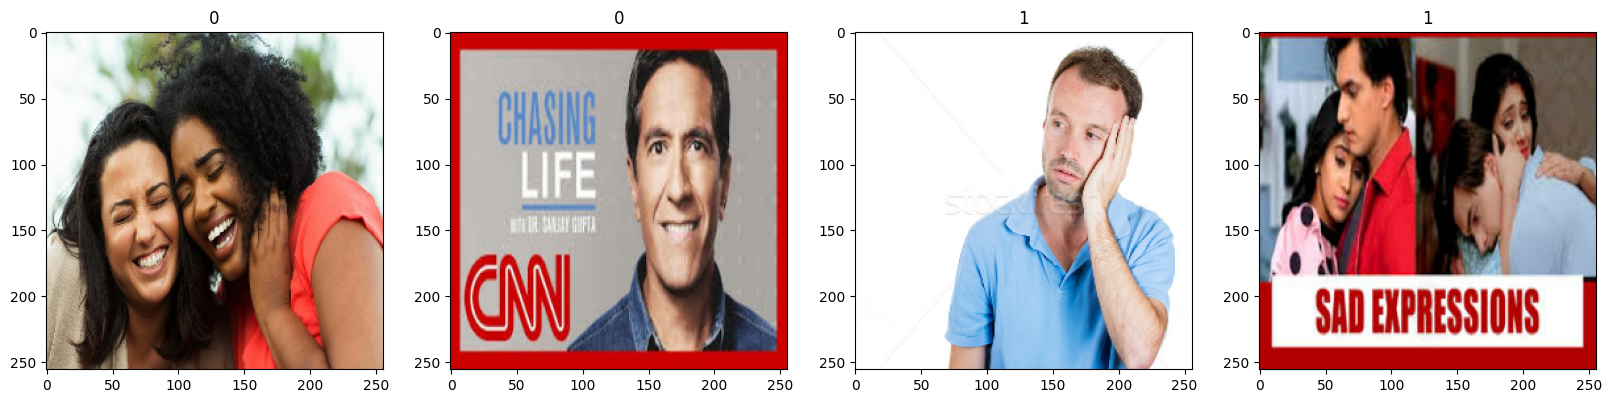

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data

2.1 Scale Data

In [16]:
data = data.map(lambda x, y: (x/255, y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].min()

0.0

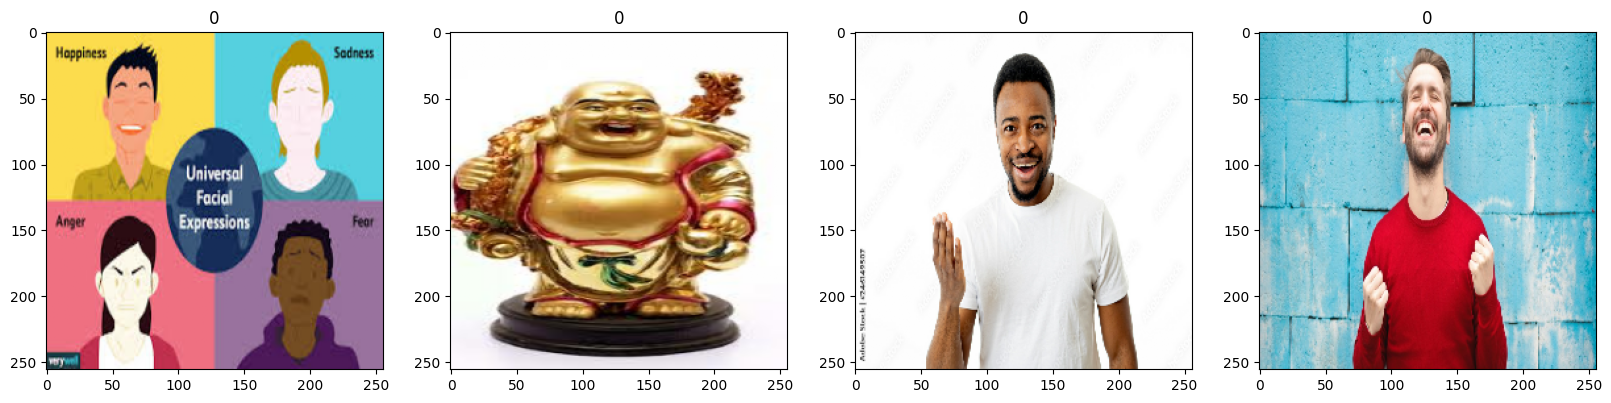

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

In [21]:
len(data)

10

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) 
test_size = int(len(data)*.1) 

In [23]:
train_size

7

In [24]:
val_size

2

In [25]:
test_size

1

In [26]:
test_size + train_size + val_size

10

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Deep Model

3.1 Build Deep Learning Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.0003)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.0003)))
model.add(MaxPooling2D()) 

model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.0003)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

3.2 Train

In [33]:
from tensorflow.keras.callbacks import TensorBoard

In [34]:
logdir = 'logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 6s 680ms/step - loss: 1.2616 - accuracy: 0.4554 - val_loss: 0.6967 - val_accuracy: 0.7344
Epoch 2/20
7/7 [==============================] - 5s 572ms/step - loss: 0.6698 - accuracy: 0.6295 - val_loss: 0.6216 - val_accuracy: 0.6719
Epoch 3/20
7/7 [==============================] - 5s 564ms/step - loss: 0.6436 - accuracy: 0.6027 - val_loss: 0.6163 - val_accuracy: 0.6406
Epoch 4/20
7/7 [==============================] - 5s 555ms/step - loss: 0.6053 - accuracy: 0.6652 - val_loss: 0.5055 - val_accuracy: 0.8125
Epoch 5/20
7/7 [==============================] - 5s 566ms/step - loss: 0.5334 - accuracy: 0.7589 - val_loss: 0.4566 - val_accuracy: 0.7500
Epoch 6/20
7/7 [==============================] - 5s 616ms/step - loss: 0.4928 - accuracy: 0.7500 - val_loss: 0.3672 - val_accuracy: 0.8281
Epoch 7/20
7/7 [==============================] - 5s 617ms/step - loss: 0.4439 - accuracy: 0.7902 - val_loss: 0.4103 - val_accuracy: 0.7969
Epoch 8/20
7/7 [====

In [37]:
hist.history

{'loss': [1.2616223096847534,
  0.6697584390640259,
  0.6436246037483215,
  0.6052610278129578,
  0.5333697199821472,
  0.4927818775177002,
  0.4439219832420349,
  0.35489773750305176,
  0.35593029856681824,
  0.2894129157066345,
  0.2134140282869339,
  0.16742531955242157,
  0.20007610321044922,
  0.20194481313228607,
  0.17330391705036163,
  0.12384390830993652,
  0.06766059249639511,
  0.06905226409435272,
  0.041203998029232025,
  0.026863427832722664],
 'accuracy': [0.4553571343421936,
  0.6294642686843872,
  0.6026785969734192,
  0.6651785969734192,
  0.7589285969734192,
  0.75,
  0.7901785969734192,
  0.8616071343421936,
  0.8392857313156128,
  0.9107142686843872,
  0.9241071343421936,
  0.9419642686843872,
  0.9017857313156128,
  0.9330357313156128,
  0.9464285969734192,
  0.9776785969734192,
  0.9821428656578064,
  0.9821428656578064,
  0.9910714030265808,
  1.0],
 'val_loss': [0.6966521739959717,
  0.6215524673461914,
  0.6163286566734314,
  0.5054770112037659,
  0.4565590023

3.3 Plot Performance 

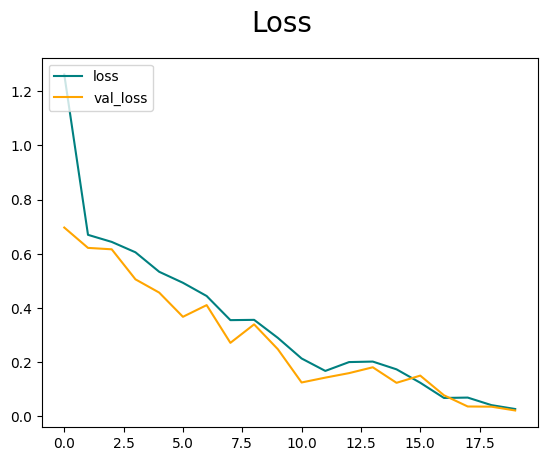

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

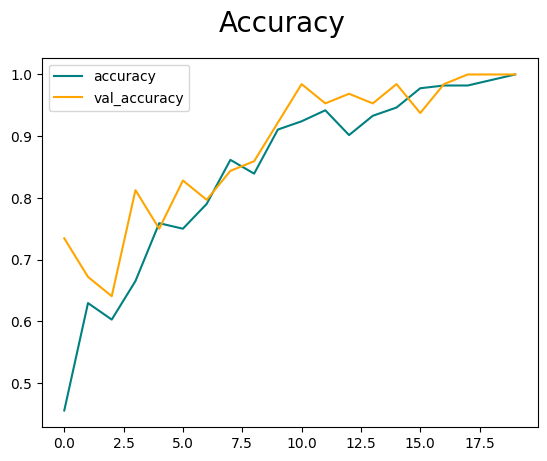

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

4.1 Evaluate 

In [55]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [56]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [57]:
len(test)

1

In [58]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    

1/1 [==============================] - 0s 28ms/step


In [59]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


4.2 Test 

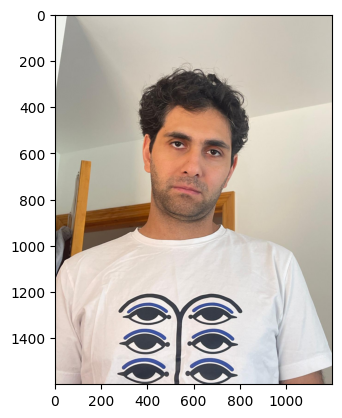

In [111]:
img = cv2.imread('sadtest4.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

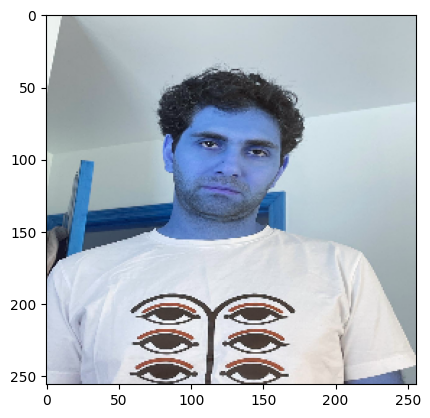

In [112]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [113]:
resize.shape

TensorShape([256, 256, 3])

In [114]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [115]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


In [116]:
yhat

array([[0.9676632]], dtype=float32)

In [117]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 5. Save the Model

5.1 Save the Model

In [95]:
from tensorflow.keras.models import load_model

In [96]:
model.save(os.path.join('models', 'happysad.h5'))

In [8]:
new_model = load_model(os.path.join('models', 'excitedangrymodelv2.h5'))